In [29]:
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import shap
import matplotlib.pyplot as plt

In [1]:
import sys
import os

# Adding the utils
module_path = os.path.abspath("../ex2_cifar10_aaron")
if module_path not in sys.path:
    sys.path.append(module_path)

from cifar10_utils import Net, load_data

In [31]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Metal Performance Shaders (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Metal Performance Shaders (MPS)


In [32]:
# Load data
train_loader, valid_loader, test_loader = load_data(batch_size=20)

Files already downloaded and verified
Files already downloaded and verified


In [33]:
model = Net()
model.load_state_dict(torch.load('../ex2_cifar10_aaron/model_cifar.pt', map_location=device))
model.eval().to(device)

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Net(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [34]:
# Helper function to preprocess input for SHAP
def preprocess_input(data):
    # Normalize the images as the model expects
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    return torch.stack([transform(img) for img in data])

In [35]:
# Helper function for SHAP
def model_predict(data):
    data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    with torch.no_grad():
        preds = model(data)
        probs = torch.nn.functional.softmax(preds, dim=1)  # Convert to probabilities
    return probs.cpu().numpy()


Shape of shap_values: [(32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10), (32, 32, 3, 10)]


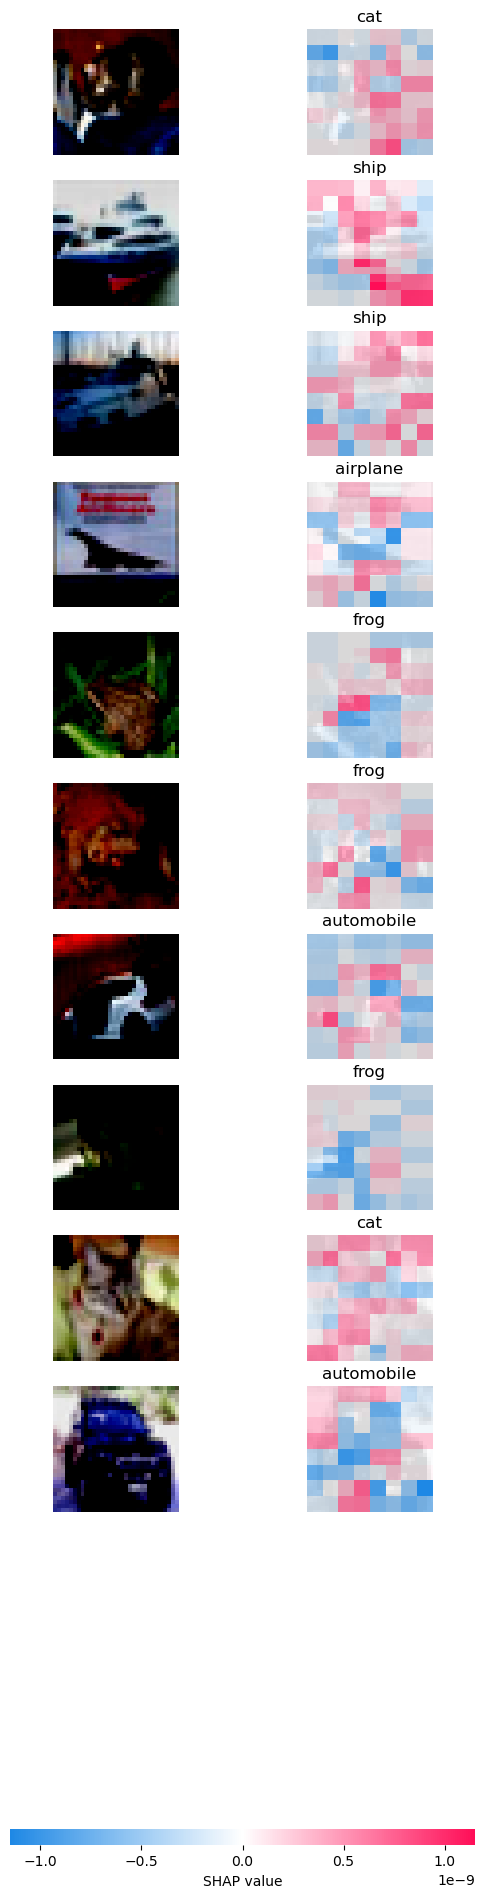

In [39]:
# Definizione delle etichette di classe
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Prepare a subset of test images for SHAP analysis
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.permute(0, 2, 3, 1).numpy()  # Convert from (N, C, H, W) to (N, H, W, C)

# Define the masker
masker = shap.maskers.Image("blur(128,128)", images[0].shape)  # Pass shape as (H, W, C)

# Update model_predict
def model_predict(data):
    data = torch.tensor(data, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
    with torch.no_grad():
        preds = model(data)
        probs = torch.nn.functional.softmax(preds, dim=1)  # Convert to probabilities
    return probs.cpu().numpy()

# Initialize SHAP explainer
explainer = shap.Explainer(model_predict, masker)

# Compute SHAP values
shap_values = explainer(images[:10])  # Use first 10 images

# Verifica delle dimensioni di shap_values
print(f"Shape of shap_values: {[v.shape for v in shap_values.values]}")

# Predizioni del modello
predictions = np.argmax(model_predict(images[:10]), axis=1)  # Class predictions for each image

# Usa le predizioni per impostare le etichette e rendile bidimensionali
labels = np.array([class_labels[pred] for pred in predictions]).reshape(-1, 1)  # Make it 2D for SHAP

# Appiattisci i valori SHAP per la visualizzazione (sommando lungo il canale colore)
shap_values_flattened = [v.sum(-1) for v in shap_values.values]  # Sum over the class dimension

# Convert SHAP values into a single array of shape (N, H, W)
shap_values_array = np.array(shap_values_flattened)

# Ensure images are in [0, 1] range
images_normalized = np.clip(images[:10], 0, 1)

# Plot SHAP values
shap.image_plot(
    shap_values_array,  # SHAP values in (N, H, W)
    images_normalized,  # Input images in (N, H, W, C)
    labels=labels       # Predicted class labels
)